In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import difflib

import sys
import time

In [2]:
NPOL = 2
OBSNCHAN = 64
NBITS = 8
BLOCSIZE = 134217728
NDIM = int(BLOCSIZE / (OBSNCHAN * NPOL * (NBITS/8)))//2
NDIM

524288

In [3]:
source_file = open("../data/blc04_guppi_57899_53848_DIAG_HIP19849_0002.0000.raw", "rb")

In [4]:
def get_sample_header(file):
    header, h_length, header_dict = read_header(file)
    bleed_data(file, header_dict)
    return header, header_dict

In [ ]:
header, header_dict = get_sample_header(source_file)
print(header)

In [5]:
pol_0 = generate_2d_normal((NDIM))
pol_1 = generate_2d_normal((NDIM))

In [6]:
bw = abs(float(header_dict["OBSBW"]))/int(header_dict["OBSNCHAN"])
total_DIM = NDIM

NameError: name 'header_dict' is not defined

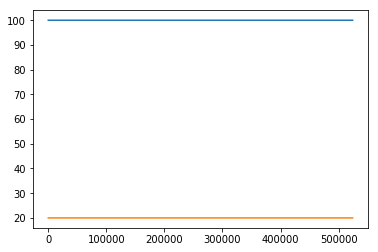

In [8]:
x = np.arange(0, NDIM/1000, 1/1000)
pol_0_real = np.ones(NDIM)*100
pol_0_imag = np.ones(NDIM)*20
plt.plot(pol_0_real)
plt.plot(pol_0_imag)

In [9]:
channel = generate_channel(NDIM, NPOL)
channel[0] = pol_0_real
channel[1] = pol_0_imag

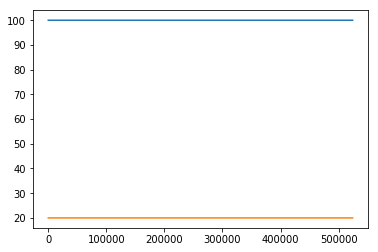

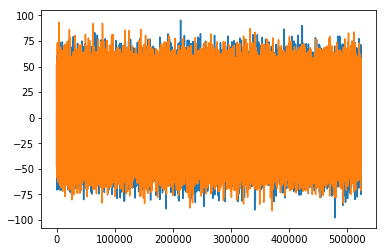

In [10]:
plt.plot(channel[0])
plt.plot(channel[1])
plt.figure()
plt.plot(channel[2])
plt.plot(channel[3])

In [11]:
channel = np.array(channel, dtype = np.int8)
channel.T.shape

(524288, 4)

In [12]:
# write
with open("test-128-64.raw", "wb") as file:
    for i in range(128):
        header, header_dict = get_sample_header(source_file)
        d = {"NPOL": 4, "OBSNCHAN": 64, "NBITS": 8,
         "BLOCSIZE": 134217728, "DIRECTIO": 1,
        "OBSERVER": "'Yuhong Chen'"}
        for key, value in d.items():
            header_dict[key] = value
        d = header_dict
        header = generate_header(d)
        file.write(header)
        for j in range(64):
            channel = generate_channel(NDIM, NPOL)
            if j == 0 or j == 32:
                channel[0] = pol_0_real
                channel[1] = pol_0_imag
            channel = np.array(channel, dtype = np.int8)
            print("Writing Channel {0} of Data Block {1}".format(j, i), end="\r", flush=True)
            file.write(channel.T.tobytes())
        print("Finished Writing Data Block {0}     ".format(i), end="\n\r", flush=True)
    print("Done")

Finished Writing Data Block 0     
Finished Writing Data Block 1     
Finished Writing Data Block 2     
Finished Writing Data Block 3     
Finished Writing Data Block 4     
Finished Writing Data Block 5     
Finished Writing Data Block 6     
Finished Writing Data Block 7     
Finished Writing Data Block 8     
Finished Writing Data Block 9     
Finished Writing Data Block 10     
Finished Writing Data Block 11     
Finished Writing Data Block 12     
Finished Writing Data Block 13     
Finished Writing Data Block 14     
Finished Writing Data Block 15     
Finished Writing Data Block 16     
Finished Writing Data Block 17     
Finished Writing Data Block 18     
Finished Writing Data Block 19     
Finished Writing Data Block 20     
Finished Writing Data Block 21     
Finished Writing Data Block 22     
Finished Writing Data Block 23     
Finished Writing Data Block 24     
Finished Writing Data Block 25     
Finished Writing Data Block 26     
Finished Writing Data Block 27     
Fi

In [ ]:
for i in range(20):
    for j in range(64):
        print("Writing Channel {0} of Data Block {1}".format(j, i), end="\r", flush=True)
    print("Finished Writing Data Block {0}     ".format(i), end="\n\r", flush=True)
print("Done")